In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal
from IPython.display import Image, display
import functools
from langchain_ollama import OllamaEmbeddings, ChatOllama
import os
from typing import Sequence
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent
from langgraph.prebuilt.tool_executor import t

from pinecone.grpc import PineconeGRPC as Pinecone
from pinecone import ServerlessSpec, PodSpec
from langchain_core.tools import tool
from langgraph.graph.message import add_messages

from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_pinecone import PineconeVectorStore 


load_dotenv()
client = os.getenv("OPENAI_API_KEY")
client_source = os.getenv("TAVILY_API_KEY")
client_pinecone = os.getenv("PINECONE_API_KEY")
oembed = OllamaEmbeddings(base_url="http://localhost:11434", model="nomic-embed-text")
pc = Pinecone(api_key=client_pinecone)
llm = ChatOpenAI(model="gpt-4o-mini")


## TOOLS _____________________________________________________________________________________TOOLS.
tavily_tool = TavilySearchResults(max_results=5)

@tool
def busca_pinecone_planos(state):
    """ ferramenta para busca de informações e preços nos planos de internet da empresa Leste Telecom """
    template = """
    Baseado no contexto abaixo, responda a pergunta:
    {context}
    Pergunta: 
    {question}

    """
    prompt = ChatPromptTemplate.from_template(template)
    index_name = "lesteplanos"
    index = pc.Index(index_name)
    text_field = "text"  
    vector_store = PineconeVectorStore(  
        index, oembed, text_field  
    )  
    retriever = vector_store.as_retriever(search_kwargs={"k": 2})
    setup_and_retrieval = RunnableParallel({"context": retriever, "question": RunnablePassthrough()})
    chain = setup_and_retrieval | prompt | llm | StrOutputParser()
    response = chain.invoke(state)
    return response

@tool
def pinecone_financy(state):
    """ Use essa ferramenta para buscar informações gerais com contato, telefone entre outros da  empresa Leste telecom."""
    
    template = """
    Baseado no contexto abaixo, responda a pergunta:

    {context}

    Pergunta: 

    {question}

    """

    prompt = ChatPromptTemplate.from_template(template)

    index_name = "lestefinanceiro"
    index = pc.Index(index_name)
    text_field = "text"  
    vector_store = PineconeVectorStore(  
        index, oembed, text_field  
    )  
    retriever = vector_store.as_retriever(search_kwargs={"k": 3})
    setup_and_retrieval = RunnableParallel({"context": retriever, "question": RunnablePassthrough()})
    chain = setup_and_retrieval | prompt | llm | StrOutputParser()
    response = chain.invoke(state)
    return response

@tool
def busca_pinecone_suporte(state):
    """ Use essa ferramenta para buscar  sobre problemas técnicos."""
    
    template = """
    Baseado no contexto abaixo, responda a pergunta:

    {context}

    Pergunta: 

    {question}

    """

    prompt = ChatPromptTemplate.from_template(template)

    index_name = "suporteprocessos"
    index = pc.Index(index_name)
    text_field = "text"  
    vector_store = PineconeVectorStore(  
        index, oembed, text_field  
    )  
    retriever = vector_store.as_retriever(search_kwargs={"k": 3})
    setup_and_retrieval = RunnableParallel({"context": retriever, "question": RunnablePassthrough()})
    chain = setup_and_retrieval | prompt | llm | StrOutputParser()
    response = chain.invoke(state)
    return response

@tool
def response_agent(state):
    '''Usar esta ferramenta para  fornecar respostas a perguntas simples dos clientes.'''
    prompt_resposta = ChatPromptTemplate.from_messages(
    [ 
        ("system",'''você é um atendente da empresa Leste telecom responsável por interação com o cliente.
         você analisa o pergunta simples do cliente e responde de forma profissional
          
         com base no histórico de mensagem e analisando a resposta dos outros trabalhadores.\
            
            ''',
        ),
        MessagesPlaceholder(variable_name="messages"),
        
    ])
    supervisor_chain = prompt_resposta | llm.with_structured_output(routeResponse)
    response  = supervisor_chain.invoke(state)
    return response





def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [AIMessage(content=result["messages"][-1].content, name=name)]
    }


members = ["timefinancy", "timecomercial", "timesuporte", "response_agent"]
#options = ["FINISH"] + members
options =  members


class routeResponse(BaseModel):
   next: Literal[*options]


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

    next: str
   
  
prompt = ChatPromptTemplate.from_messages(

    [
        ("system", '''
                    Você é um atendente da empresa Leste telecom seu trabalho e intermediar a interação do usuário\
                    buscando a respostas nas ferramentas disponibilizadas\
                    Responda diretamente ao cliente para perguntas simples \
                    para as demais perguntas selecione a melhor equipe para fornecer as respostas\
                    você possui a seguinte lista de ferramentas: {members}. 
                    Exemplo:\
                    - para pergunta corriqueiras ou de contato inicial use a ferramenta response_agent.       
                    - para informações gerais como contato ou dúvidas use: timefinancy  
                    - Para  buscar valores dos planos de internet da Leste use a ferramenta timecomercial
                    - Para problemas técnicos use: timesuporte
                    '''),
        MessagesPlaceholder(variable_name="messages"),
        
        (
            "system",'''Dada a conversa acima, escolha o time que deve agir em seguida, escolha entre as equipes a seguir.
            ao receber a resposta correta finalize com FINISH. Para rptear uma equipe retorne o nome da ferramenta entre as opções: {options} ''',
        ),
    ]
).partial(options=str(options), members=", ".join(members))
llm = ChatOpenAI(model="gpt-4o-mini")



## AGENTS___________________________________________________________________________________________________AGENTS.

def supervisor_agent(state):
    print("Supervisor chamado com estado:", state)
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    response = supervisor_chain.invoke(state)
    print("Resposta do supervisor:", response)
    return response

financy_agent = create_react_agent(llm, tools=[pinecone_financy])
financy_node = functools.partial(agent_node, agent=financy_agent, name="timefinancy")

comercial_agent = create_react_agent(llm, tools=[busca_pinecone_planos])
comercial_node = functools.partial(agent_node, agent=comercial_agent, name="timecomercial")

suporte_agent = create_react_agent(llm, tools=[busca_pinecone_planos])
suporte_node = functools.partial(agent_node, agent=suporte_agent, name="timesuporte")

response_user_agent = create_react_agent(llm, tools= [response_agent])
response_node = functools.partial(agent_node, agent=response_user_agent, name="response_agent")

## GRAPH____________________________________________________________________________________________________GRAPH.
workflow = StateGraph(AgentState)

workflow.add_node("timefinancy", financy_node)
workflow.add_node("timecomercial", comercial_node)
workflow.add_node("timesuporte", suporte_node)
workflow.add_node("response_agent", response_node)
workflow.add_node("supervisor", supervisor_agent)

#ARESTAS
workflow.add_edge("timefinancy", "supervisor")
workflow.add_edge("timecomercial", "supervisor")
workflow.add_edge("timesuporte", "supervisor")
workflow.add_edge("response_agent", END)

workflow.add_conditional_edges("supervisor", 
                               lambda x: x["next"], 
                               {END:END,"timefinancy":"timefinancy","timecomercial":"timecomercial","timesuporte":"timesuporte", "response_agent":"response_agent"}
                               )
#workflow.add_conditional_edges("response_agent", lambda x: x["next"], {})

workflow.add_edge(START, "supervisor")
graph = workflow.compile()


## INPUTS__________________________________________________________________________________________________
question  = input("digite sua pergunta")
while question.lower() != "sair":
    response = graph.invoke(
        {"messages": [HumanMessage(content=question)]}
    )
    print(response["messages"][-1].content)
    question  = input("digite sua pergunta")





d:\workstation\openweb\venv\Lib\site-packages\pinecone\data\index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Supervisor chamado com estado: {'messages': [HumanMessage(content='olá', additional_kwargs={}, response_metadata={}, id='c33275ad-6ec0-449f-9f77-de7f006eec96')]}
Resposta do supervisor: next='response_agent'
Olá! Como posso ajudar você hoje?
Supervisor chamado com estado: {'messages': [HumanMessage(content='olá', additional_kwargs={}, response_metadata={}, id='a92a908c-9a91-4cc3-b3e2-d2701838f5a2')]}
Resposta do supervisor: next='response_agent'
Olá! Como posso ajudar você hoje?
Supervisor chamado com estado: {'messages': [HumanMessage(content='o que vc faz?', additional_kwargs={}, response_metadata={}, id='865a26d3-560a-4f22-bc45-efae31fb1c65')]}
Resposta do supervisor: next='response_agent'
Eu sou um assistente virtual, projetado para ajudar a responder perguntas e fornecer informações sobre uma variedade de tópicos. Posso ajudar com dúvidas, fornecer explicações, e muito mais. Como posso ajudá-lo hoje?
Supervisor chamado com estado: {'messages': [HumanMessage(content='Me fale sobre 

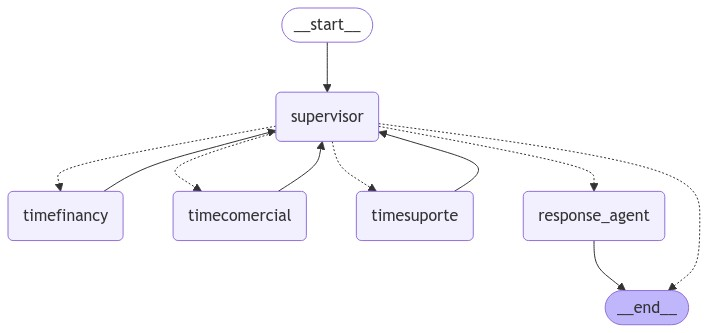

In [ ]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass
